In [45]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import pandas_datareader as web
import talib as ta


In [46]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date,
                      end = end_date,
                      progress = False)

data["Date"] = data.index
data = data[["Date", "Open", "High", "Low","Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace = True)
print(data.head)

<bound method NDFrame.head of           Date        Open        High         Low       Close   Adj Close  \
0   2021-11-02  144.809402  146.920502  144.641006  145.863007  145.863007   
1   2021-11-03  146.274994  146.910507  145.053497  146.789993  146.789993   
2   2021-11-04  147.199997  149.949997  146.634995  148.682999  148.682999   
3   2021-11-05  149.353500  150.570755  148.651993  149.240997  149.240997   
4   2021-11-08  150.000000  151.034500  149.119995  149.351501  149.351501   
..         ...         ...         ...         ...         ...         ...   
247 2022-10-26   96.760002   98.540001   94.570000   94.820000   94.820000   
248 2022-10-27   94.309998   95.169998   91.900002   92.599998   92.599998   
249 2022-10-28   92.529999   96.860001   92.322998   96.580002   96.580002   
250 2022-10-31   95.779999   96.349998   94.379997   94.660004   94.660004   
251 2022-11-01   95.589996   96.165001   90.430000   90.500000   90.500000   

       Volume  
0    21150000  
1

In [47]:
data2 = web.data.DataReader("AAPL", "yahoo",start="2020-09-10", end=end_date)

In [48]:
data2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-10,120.500000,112.500000,120.360001,113.489998,182274400.0,112.136337
2020-09-11,115.230003,110.000000,114.570000,112.000000,180860300.0,110.664108
2020-09-14,115.930000,112.800003,114.720001,115.360001,140150100.0,113.984055
2020-09-15,118.830002,113.610001,118.330002,115.540001,184642000.0,114.161903
2020-09-16,116.000000,112.040001,115.230003,112.129997,154679000.0,110.792580
...,...,...,...,...,...,...
2022-10-26,151.990005,148.039993,150.960007,149.350006,88194300.0,149.350006
2022-10-27,149.050003,144.130005,148.070007,144.800003,109180200.0,144.800003
2022-10-28,157.500000,147.820007,148.199997,155.740005,164762400.0,155.740005


In [49]:
actions = web.DataReader('GOOG', 'yahoo-actions', start_date, end_date)

In [50]:
dividends = web.DataReader('IBM', 'yahoo-dividends', start_date, end_date)

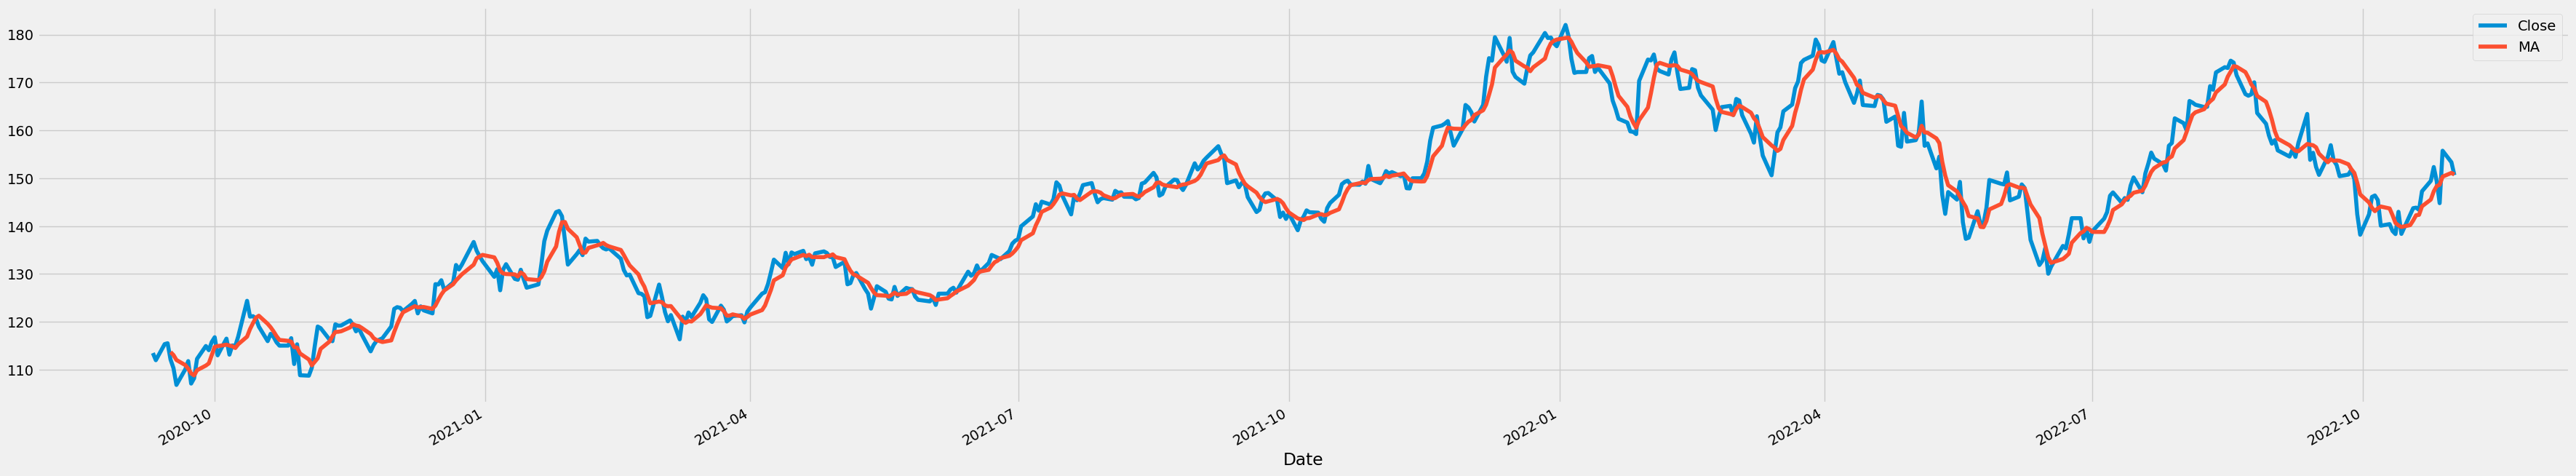

In [51]:
plt.style.use('fivethirtyeight')
data2['MA'] = ta.SMA(data2['Close'],timeperiod=5)
data2[['Close','MA']].plot(figsize=(40,8))
plt.show()

In [52]:
data2

,High,Low,Open,Close,Volume,Adj Close,MA
Date,,,,,,,
2020-09-10,120.500000,112.500000,120.360001,113.489998,182274400.0,112.136337,NaN
2020-09-11,115.230003,110.000000,114.570000,112.000000,180860300.0,110.664108,NaN
2020-09-14,115.930000,112.800003,114.720001,115.360001,140150100.0,113.984055,NaN
2020-09-15,118.830002,113.610001,118.330002,115.540001,184642000.0,114.161903,NaN
2020-09-16,116.000000,112.040001,115.230003,112.129997,154679000.0,110.792580,113.703999
...,...,...,...,...,...,...,...
2022-10-26,151.990005,148.039993,150.960007,149.350006,88194300.0,149.350006,148.360001
2022-10-27,149.050003,144.130005,148.070007,144.800003,109180200.0,144.800003,148.642001
2022-10-28,157.500000,147.820007,148.199997,155.740005,164762400.0,155.740005,150.336002


In [53]:
data2["RSI"] = ta.RSI(data2["Close"])
data2

,High,Low,Open,Close,Volume,Adj Close,MA,RSI
Date,,,,,,,,
2020-09-10,120.500000,112.500000,120.360001,113.489998,182274400.0,112.136337,NaN,NaN
2020-09-11,115.230003,110.000000,114.570000,112.000000,180860300.0,110.664108,NaN,NaN
2020-09-14,115.930000,112.800003,114.720001,115.360001,140150100.0,113.984055,NaN,NaN
2020-09-15,118.830002,113.610001,118.330002,115.540001,184642000.0,114.161903,NaN,NaN
2020-09-16,116.000000,112.040001,115.230003,112.129997,154679000.0,110.792580,113.703999,NaN
...,...,...,...,...,...,...,...,...
2022-10-26,151.990005,148.039993,150.960007,149.350006,88194300.0,149.350006,148.360001,53.288518
2022-10-27,149.050003,144.130005,148.070007,144.800003,109180200.0,144.800003,148.642001,46.811996
2022-10-28,157.500000,147.820007,148.199997,155.740005,164762400.0,155.740005,150.336002,59.543661


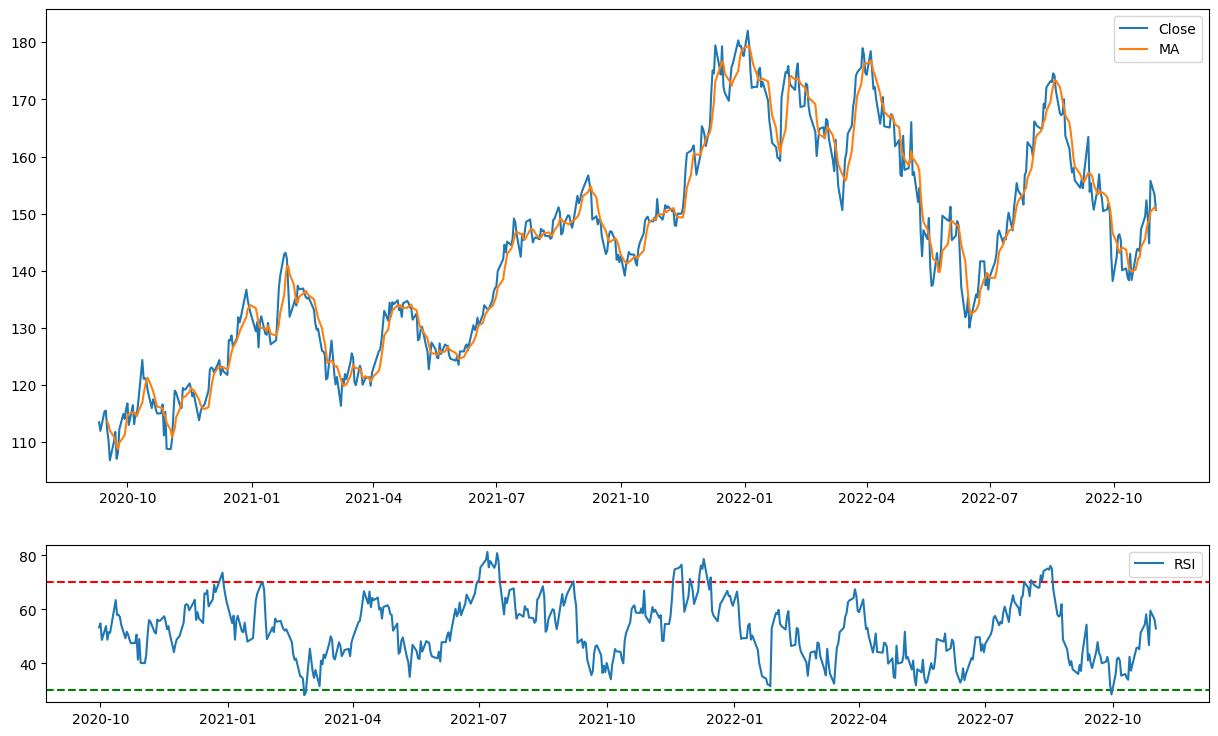

In [85]:
fig, axs =plt.subplots(2,1, gridspec_kw={"height_ratios": [3,1]}, figsize=(15,9))
plt.style.use("default")
# axs[0].plot(data2[['Close',"MA"]], label=["Close", "MA"])
axs[0].plot(data2['Close'], label="Close")
axs[0].plot(data2["MA"], label= "MA")
axs[0].legend(loc="best")
axs[1].axhline(y=70, color="r", linestyle="--")
axs[1].axhline(y=30, color="g", linestyle="--")
axs[1].plot(data2["RSI"], label="RSI")
axs[1].legend(loc="best")


In [92]:
data2["LinearReg"] = ta.LINEARREG(data2["Close"], 100)

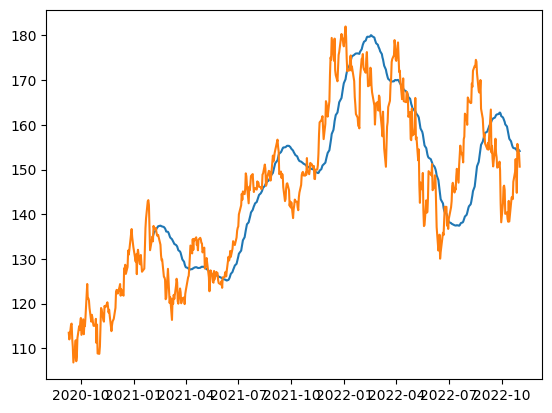

In [94]:
plt.plot(data2["LinearReg"])
plt.plot(data2["Close"])


In [55]:
px.line(data, x='Date', y='Close', 
                 title='Stock Market Analysis with Rangeslider')


In [56]:
figure = go.Figure(data=[go.Candlestick(x=data["Date"],
                                        open=data["Open"], high=data["High"],
                                        low=data["Low"], close=data["Close"])])
figure.update_layout(title = "Google Stock Price Analysis", xaxis_rangeslider_visible=False)
figure.show()

<BarContainer object of 252 artists>

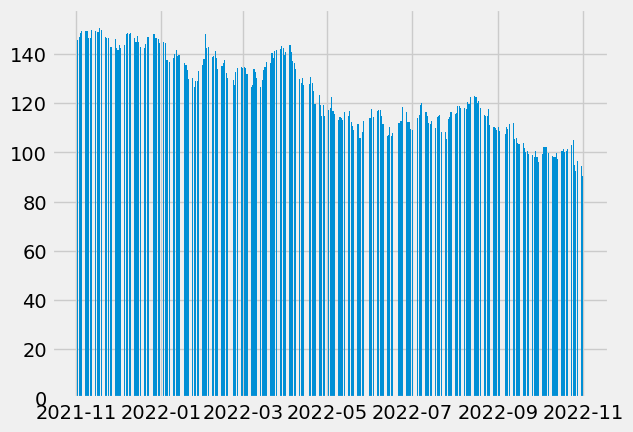

In [57]:
plt.bar(x=data["Date"], height=data["Close"]
)

In [58]:
meta = yf.Ticker("META")
df = meta.history(start=start_date)
df
# meta.actions

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-11-02 00:00:00-04:00,331.380005,334.790009,323.799988,328.079987,28353000,0,0
2021-11-03 00:00:00-04:00,327.489990,332.149994,323.200012,331.619995,20786500,0,0
2021-11-04 00:00:00-04:00,334.010010,337.269989,332.649994,335.850006,22495300,0,0
2021-11-05 00:00:00-04:00,340.309998,346.790009,339.640015,341.130005,26872800,0,0
2021-11-08 00:00:00-05:00,344.420013,344.790009,338.339996,338.619995,18342500,0,0
...,...,...,...,...,...,...,...
2022-10-26 00:00:00-04:00,131.679993,135.550003,128.529999,129.820007,82791500,0,0
2022-10-27 00:00:00-04:00,97.980003,102.500000,96.379997,97.940002,232316600,0,0
2022-10-28 00:00:00-04:00,99.580002,100.849998,97.510002,99.199997,95928300,0,0


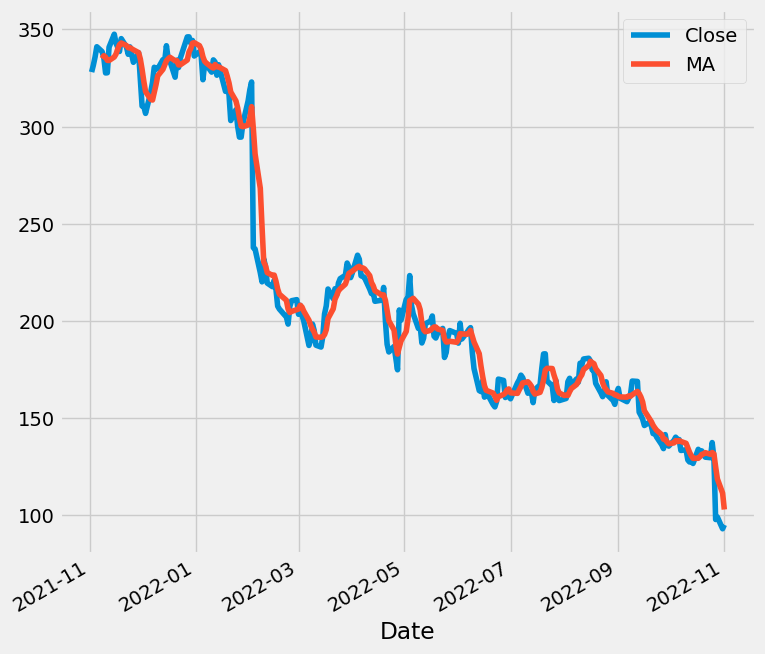

In [59]:
plt.style.use('fivethirtyeight')
df['MA'] = ta.SMA(df['Close'],timeperiod=5)
df[['Close','MA']].plot(figsize=(8,8))
plt.show()

<AxesSubplot: xlabel='Date'>

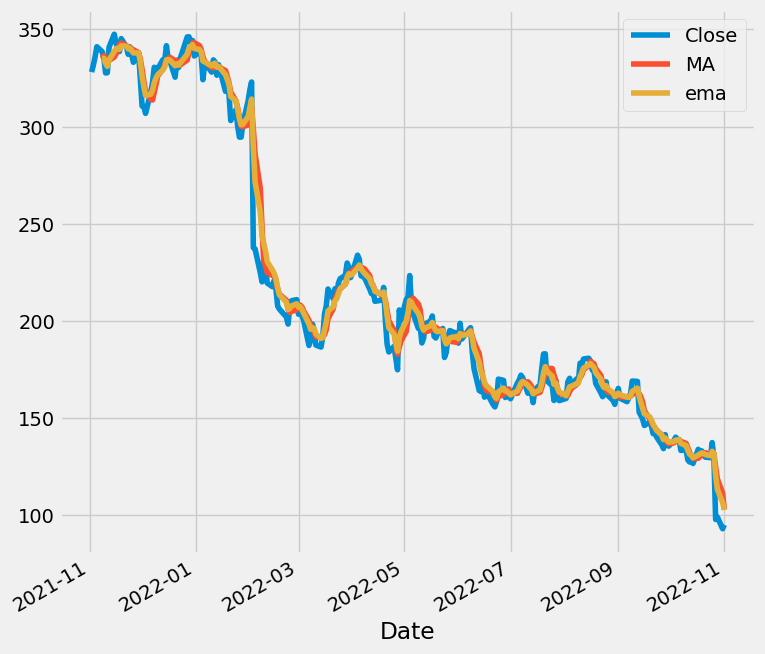

In [60]:
plt.style.use('fivethirtyeight')
df['ema'] = ta.EMA(df['Close'],timeperiod=5)
df[['Close','MA','ema']].plot(figsize=(8,8))

What is Relative Strength Index(RSI)
RSI is a momentum indicator that helps to learn whether a certain share is overbought or oversold. Its value lies between 0-100. If it is under 30, it means it is oversold and has a chance to buy it. If the value lies above 70, it means it is overbought and it is a good chance to dump your stock. Let’s calculate and chart the RSI of the FB/Meta stock. Let’s check the RSI of FB.

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,ema,RSI
Date,,,,,,,,,,
2022-10-19 00:00:00-04:00,132.889999,137.000000,132.220001,133.229996,30691000,0,0,131.423997,132.194760,41.833900
2022-10-20 00:00:00-04:00,132.929993,136.770004,131.309998,131.529999,26356300,0,0,131.671999,131.973173,40.069644
2022-10-21 00:00:00-04:00,126.309998,130.119995,125.440002,130.009995,46195500,0,0,132.321997,131.318780,38.505983
2022-10-24 00:00:00-04:00,127.250000,133.479996,124.570000,129.720001,63563400,0,0,131.457999,130.785854,38.199705
2022-10-25 00:00:00-04:00,130.880005,138.350006,130.589996,137.509995,38433200,0,0,132.399997,133.027234,49.760030
2022-10-26 00:00:00-04:00,131.679993,135.550003,128.529999,129.820007,82791500,0,0,131.717999,131.958159,41.506039
2022-10-27 00:00:00-04:00,97.980003,102.500000,96.379997,97.940002,232316600,0,0,125.000000,120.618773,23.846358
2022-10-28 00:00:00-04:00,99.580002,100.849998,97.510002,99.199997,95928300,0,0,118.838000,113.479181,25.200932
2022-10-31 00:00:00-04:00,98.220001,99.320000,92.599998,93.160004,121361400,0,0,111.526001,106.706122,23.081459


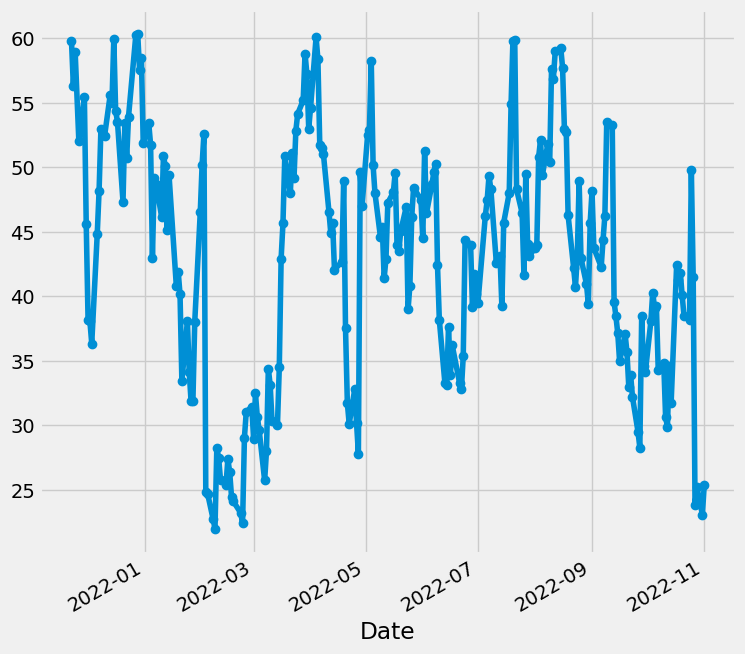

In [61]:
df['RSI'] = ta.RSI(df['Close'],14)
df['RSI'].plot(figsize=(8,8),marker='o')
df.tail(10)

In [62]:
rsi = ta.RSI(df["Close"], timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 Date
2021-11-22 00:00:00-05:00    59.761462
2021-11-23 00:00:00-05:00    56.318216
2021-11-24 00:00:00-05:00    58.902178
2021-11-26 00:00:00-05:00    51.998827
2021-11-29 00:00:00-05:00    55.474087
2021-11-30 00:00:00-05:00    45.639442
2021-12-01 00:00:00-05:00    38.191983
2021-12-02 00:00:00-05:00    38.090567
2021-12-03 00:00:00-05:00    36.334005
2021-12-06 00:00:00-05:00    44.844663
dtype: float64


In [63]:

def bbp(price):
    up, mid, low = ta.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price['AdjClose'] - low) / (up - low)
    return bbp

In [64]:
holdings = pd.DataFrame(index=price.index, data={'Holdings': np.array([np.nan] * index.shape[0])})
holdings.loc[((price['RSI'] < 30) & (price['BBP'] < 0)), 'Holdings'] = max_holding
holdings.loc[((price['RSI'] > 70) & (price['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

NameError: name 'price' is not defined

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(index, price['AdjClose'], label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='red')

ax1.plot(index, price['RSI'], label='RSI')
ax1.fill_between(index, y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(index, price['BB_up'], label='BB_up')
ax2.plot(index, price['AdjClose'], label='AdjClose')
ax2.plot(index, price['BB_low'], label='BB_low')
ax2.fill_between(index, y1=price['BB_low'], y2=price['BB_up'], color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()